In [1]:
import cv2
import mediapipe as mp
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lightning as L
import torch
import torch.nn as nn
import torch.nn.functional as F
import joblib

from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
def extractLandmarks(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found or unable to read.")
    h, w = image.shape[:2]

    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    with mp.solutions.hands.Hands(static_image_mode=True) as hands:
        results = hands.process(rgb)

    if results.multi_hand_landmarks:
        hand_landmarks = results.multi_hand_landmarks[0]
        coords = [coord for lm in hand_landmarks.landmark for coord in (lm.x, lm.y, lm.z)]
        return coords, (h, w)
    else:
        return None, None


In [3]:
def flip_horizontal(lms):
    lms = np.array(lms).reshape(21, 3)
    lms[:, 0] = 1.0 - lms[:, 0]
    return lms.flatten().tolist()

def rotate(lms, angle_deg=15):
    lms = np.array(lms).reshape(21, 3)
    angle_rad = np.radians(np.random.uniform(-angle_deg, angle_deg))
    rot = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                    [np.sin(angle_rad),  np.cos(angle_rad)]])
    centered = lms[:, :2] - 0.5
    rotated = centered @ rot.T
    lms[:, :2] = np.clip(rotated + 0.5, 0, 1)
    return lms.flatten().tolist()

def scale(lms, scale_range=(0.8, 1.2)):
    lms = np.array(lms).reshape(21, 3)
    s = np.random.uniform(*scale_range)
    center = np.mean(lms[:, :2], axis=0)
    lms[:, :2] = (lms[:, :2] - center) * s + center
    return np.clip(lms, 0, 1).flatten().tolist()

def translate(lms, max_shift=0.05):
    lms = np.array(lms).reshape(21, 3)
    shift = np.random.uniform(-max_shift, max_shift, size=2)
    lms[:, :2] += shift
    return np.clip(lms, 0, 1).flatten().tolist()

def add_noise(lms, std=0.01):
    lms = np.array(lms).reshape(21, 3)
    noise = np.random.normal(0, std, lms.shape)
    lms += noise
    return np.clip(lms, 0, 1).flatten().tolist()


In [4]:
x = []
y = []
image_paths = []
image_sizes = []

AUG_FUNCS = [flip_horizontal, rotate, scale, translate, add_noise]

for label in os.listdir("../LSM_FullBody/images_sorted"):
    for img_file in os.listdir(f'../LSM_FullBody/images_sorted/{label}'):
        path = f'../LSM_FullBody/images_sorted/{label}/{img_file}'
        landmarks, size = extractLandmarks(path)
        if landmarks is not None:
            # Original
            x.append(landmarks)
            y.append(label)
            image_paths.append(path)
            image_sizes.append(size)

            # Augmented
            for func in AUG_FUNCS:
                aug = func(landmarks)
                x.append(aug)
                y.append(label)
                image_paths.append(path + f"_aug_{func.__name__}")
                image_sizes.append(size)

In [5]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
joblib.dump(le, 'label_encoder.pkl')

['label_encoder.pkl']

In [6]:

df = pd.DataFrame(x)
df["label"] = y_encoded
df["image_path"] = image_paths
df["height"] = [h for h, w in image_sizes]
df["width"] = [w for h, w in image_sizes]

df.to_csv("landmarks_dataset.csv", index=False)


In [7]:
df = pd.read_csv("../LSM-V2/landmarks_dataset.csv")

# Separar X (landmarks), y, paths y tamaños
x = df.iloc[:, :63].values.tolist()
y = df["label"].tolist()
image_paths = df["image_path"].tolist()
image_sizes = list(zip(df["height"], df["width"]))


In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def draw_landmarks_on_image_with_size_matplotlib(image_path, landmarks_flat, size):
    # Si es una imagen aumentada virtual, recorta hasta el path original
    if not os.path.isfile(image_path):
        image_path = image_path.split("_aug_")[0]

    # Carga la imagen
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found or unable to read: {image_path}")

    h, w = size
    landmarks = np.array(landmarks_flat).reshape(21, 3)

    # Dibuja los puntos sobre la imagen
    for (x_, y_, _) in landmarks:
        px = int(x_ * w)
        py = int(y_ * h)
        cv2.circle(img, (px, py), 5, (0, 255, 0), -1)

    # Mostrar usando matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title("Landmarks sobre imagen original")
    plt.show()


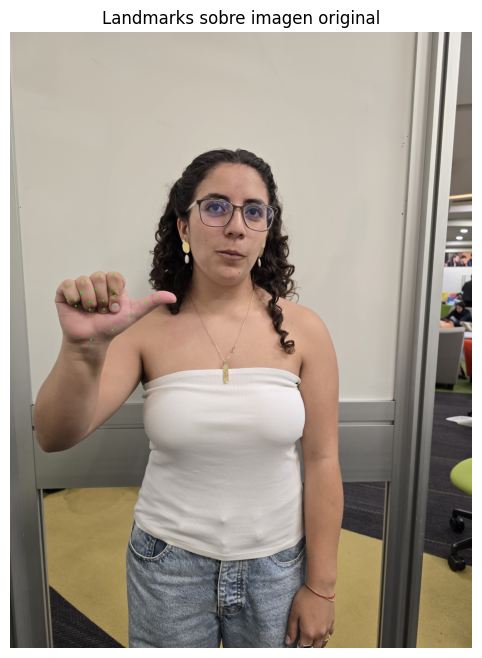

In [17]:
draw_landmarks_on_image_with_size_matplotlib(
    image_paths[0], x[0], image_sizes[0]
)

In [20]:
class HandLandmarksModel(L.LightningModule):
    def __init__(self, input_size=63, num_classes=26, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        self.log("train_acc", acc)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('val_loss', loss)
        self.log("val_acc", acc)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
    

In [21]:
class LandmarkDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [22]:
dataset = LandmarkDataset(x, y_encoded)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = HandLandmarksModel(input_size=63, num_classes=len(le.classes_), lr=1e-3)

trainer = L.Trainer(
    max_epochs=500,
    accelerator="auto",
    logger=CSVLogger(save_dir="logs/", name="lsm-cnn-modelv2"),
    callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=5)],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [23]:
trainer.fit(model, train_loader, val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 202 K  | train
---------------------------------------------
202 K     Trainable params
0         Non-trainable params
202 K     Total params
0.809     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

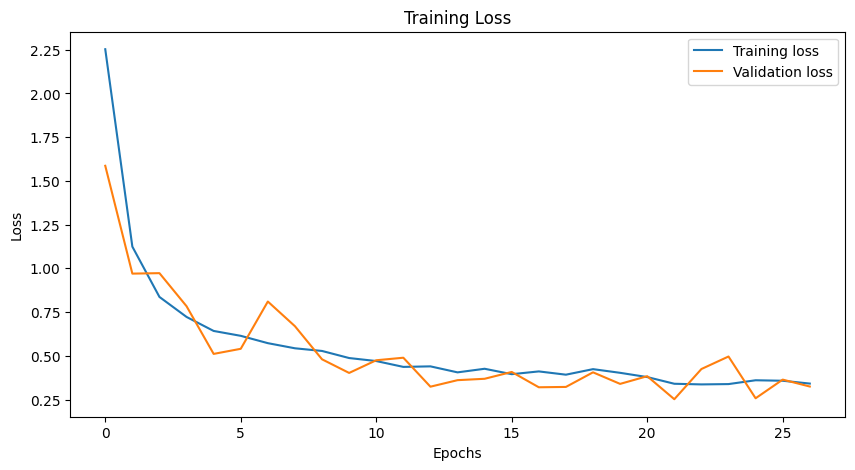

In [24]:
# Read the metrics.csv file generated by the PyTorch Lightning logger
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
# Group the metrics by epoch and compute the mean loss for each epoch
df_epochs = metrics.groupby('epoch').mean()

# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# Set the x-axis label
ax.set_xlabel('Epochs')
# Set the y-axis label
ax.set_ylabel('Loss')
# Plot the training loss over epochs
ax.plot(df_epochs['train_loss'], label="Training loss")
# Plot the validation loss over epochs
ax.plot(df_epochs['val_loss'], label="Validation loss")
# Set the title of the plot
ax.set_title("Training Loss")
# Add a legend to the plot
ax.legend(loc='upper right')

In [25]:
# modelo = HandLandmarksModel(...)
torch.save(model.model.state_dict(), "hand_landmarks_modelv2.pt")
